# Step #1 Load the Data

In [4]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler
# For detailed configuration of the optimizer 
from keras.optimizers import Adam
import seaborn as sns

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Quick overview of dataset
train_dfs = df.copy()
train_dfs

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,2311.149902,2294.409912,2294.409912,2308.419922,1931380000,2308.419922
2010-01-05,2313.729980,2295.620117,2307.270020,2308.709961,2367860000,2308.709961
2010-01-06,2314.070068,2295.679932,2307.709961,2301.090088,2253340000,2301.090088
2010-01-07,2301.300049,2285.219971,2298.090088,2300.050049,2270050000,2300.050049
2010-01-08,2317.600098,2290.610107,2292.239990,2317.169922,2145390000,2317.169922
...,...,...,...,...,...,...
2021-06-18,14129.219727,14009.040039,14096.929688,14030.379883,6105960000,14030.379883
2021-06-21,14150.780273,13960.040039,14047.419922,14141.480469,4523120000,14141.480469
2021-06-22,14269.769531,14121.000000,14138.290039,14253.269531,4405260000,14253.269531


# Step #2 Explore the Data

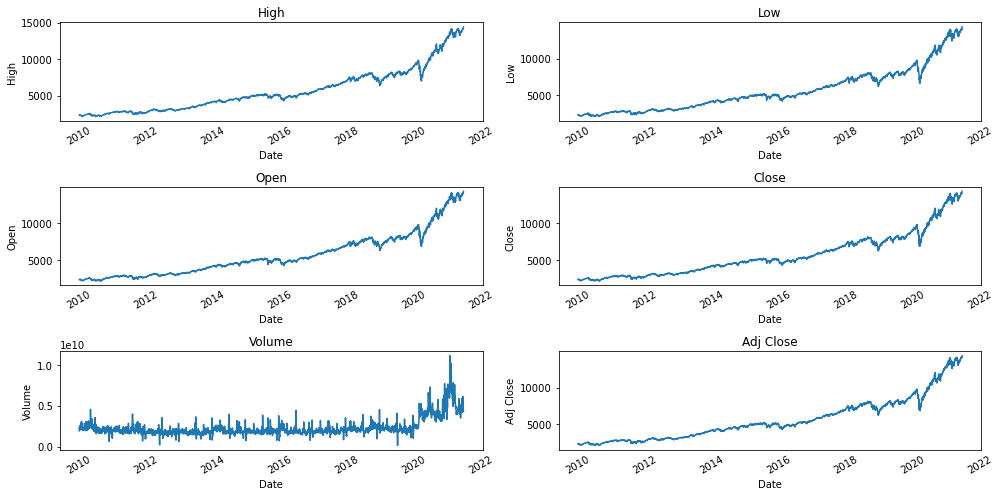

In [5]:
# Plot histograms
df_plot = train_dfs.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Feature Engineering

In [5]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index
date_index_df = pd.DataFrame(date_index)

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Day'] = d.strftime("%d") 
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df.reset_index(level=0, inplace=True)
train_df.tail(5)

,Date,High,Low,Open,Close,Volume,Adj Close,Day,Month,Year
2880,2021-06-14,14175.450195,14056.669922,14083.469727,14174.139648,4394380000,14174.139648,14,06,2021
2881,2021-06-15,14171.019531,14052.160156,14166.639648,14072.860352,4517770000,14072.860352,15,06,2021
2882,2021-06-16,14129.690430,13903.730469,14085.549805,14039.679688,4632480000,14039.679688,16,06,2021
2883,2021-06-17,14196.209961,13998.929688,13999.129883,14161.349609,4526780000,14161.349609,17,06,2021
2884,2021-06-18,14129.219727,14009.040039,14096.929688,14030.379883,6105960000,14030.379883,18,06,2021


In [6]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    return df

             Close       Date  Bollinger_Upper  Bollinger_Lower    Prediction
2880  14174.139648 2021-06-14     14206.451413     13237.008645  14174.139648
2881  14072.860352 2021-06-15     14237.172054     13275.669060  14072.860352
2882  14039.679688 2021-06-16     14239.485862     13346.959255  14039.679688
2883  14161.349609 2021-06-17     14246.910057     13425.695998  14161.349609
2884  14030.379883 2021-06-18     14254.651319     13467.418700  14030.379883


<function matplotlib.pyplot.show(close=None, block=None)>

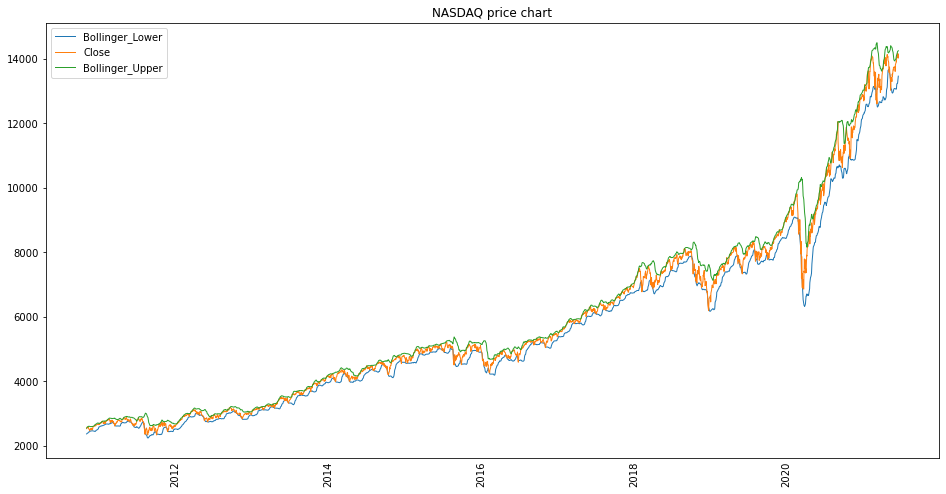

In [7]:
# List of considered Features
FEATURES = [
#             'High',
#             'Low',
#             'Open',
              'Close',
#             'Volume',
              'Date',
#             'Day',
#             'Month',
#             'Year',
#             'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
#             'MACD',
#             'RSI',
#             'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
#             'MA100',            
#             'MA50',
#             'MA26',
#             'MA14_low',
#             'MA14_high',
#             'MA12',
#             'EMA20',
#             'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE'
           ]

# Create the dataset with features
data = createFeatures(train_df)

# Shift the timeframe by 10 month
use_start_date = pd.to_datetime("2010-11-01" )
data = data[data['Date'] > use_start_date].copy()

# Filter the data to the list of FEATURES
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close'] 
print(data_filtered_ext.tail().to_string())

# remove Date column before training
dfs = data_filtered_ext.copy()
del dfs[('Date')]
del dfs[('Prediction')]

# Register matplotlib converters
register_matplotlib_converters()

# Define plot parameters 
nrows = dfs.shape[1]
fig, ax = plt.subplots(figsize=(16, 8))
x = data_filtered_ext['Date']
assetname_list = []

# Plot each column
for i in range(nrows):
    assetname = dfs.columns[i-1]
    y = data_filtered_ext[assetname]
    ax.plot(x, y, label=assetname, linewidth=1.0)
    assetname_list.append(assetname)

# Configure and show the plot    
ax.set_title(stockname + ' price chart')
ax.legend()
ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)   
plt.show

# Step #4 Scaling and Transforming the Data

In [8]:
# Calculate the number of rows in the data
nrows = dfs.shape[0]
np_data_unscaled = np.reshape(np.array(dfs), (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2675, 3)


In [9]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[0:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2090, 50, 1) (2090,)
(535, 50, 1) (535,)
-0.5726079413373497
-0.5726079413373497


# Step #5 Model Training

timesteps: 50, features:1
Parameters: ['epochs 100', 'batch_size 32', 'patience 8', 'optimizer adam with learn rate 0.05', 'loss mean_squared_error']
Epoch 1/100
66/66 [==============================] - 4s 65ms/step - loss: 0.1030 - val_loss: 0.2774
Epoch 2/100
66/66 [==============================] - 3s 42ms/step - loss: 0.0945 - val_loss: 0.2320
Epoch 3/100
66/66 [==============================] - 3s 40ms/step - loss: 0.0944 - val_loss: 0.1909
Epoch 4/100
66/66 [==============================] - 3s 39ms/step - loss: 0.0945 - val_loss: 0.2489
Epoch 5/100
66/66 [==============================] - 3s 39ms/step - loss: 0.0946 - val_loss: 0.1744
Epoch 6/100
66/66 [==============================] - 3s 39ms/step - loss: 0.0943 - val_loss: 0.1445
Epoch 7/100
66/66 [==============================] - 3s 41ms/step - loss: 0.0944 - val_loss: 0.1638
Epoch 8/100
66/66 [==============================] - 3s 40ms/step - loss: 0.0944 - val_loss: 0.1163
Epoch 9/100
66/66 [==============================]

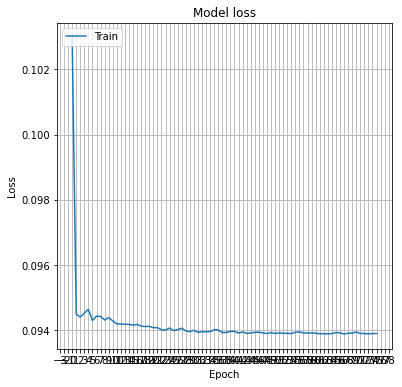

In [10]:
# Configure the neural network model
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1, activation='relu'))

# Configure the Model  
optimizer='adam'; loss='mean_squared_error'; epochs = 100; batch_size = 32; patience = 8; learn_rate = 0.05
adam = Adam(lr=learn_rate)
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], shuffle = True,
                  validation_data=(x_test, y_test))

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(6, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #6 Evaluate Model Performance

Mean Absolute Percentage Error (MAPE): 3.38 %
Median Absolute Percentage Error (MDAPE): 2.45 %
Mean Absolute Error (MAE): 393.6382
Mean Squared Error (MSE): 295107.7557


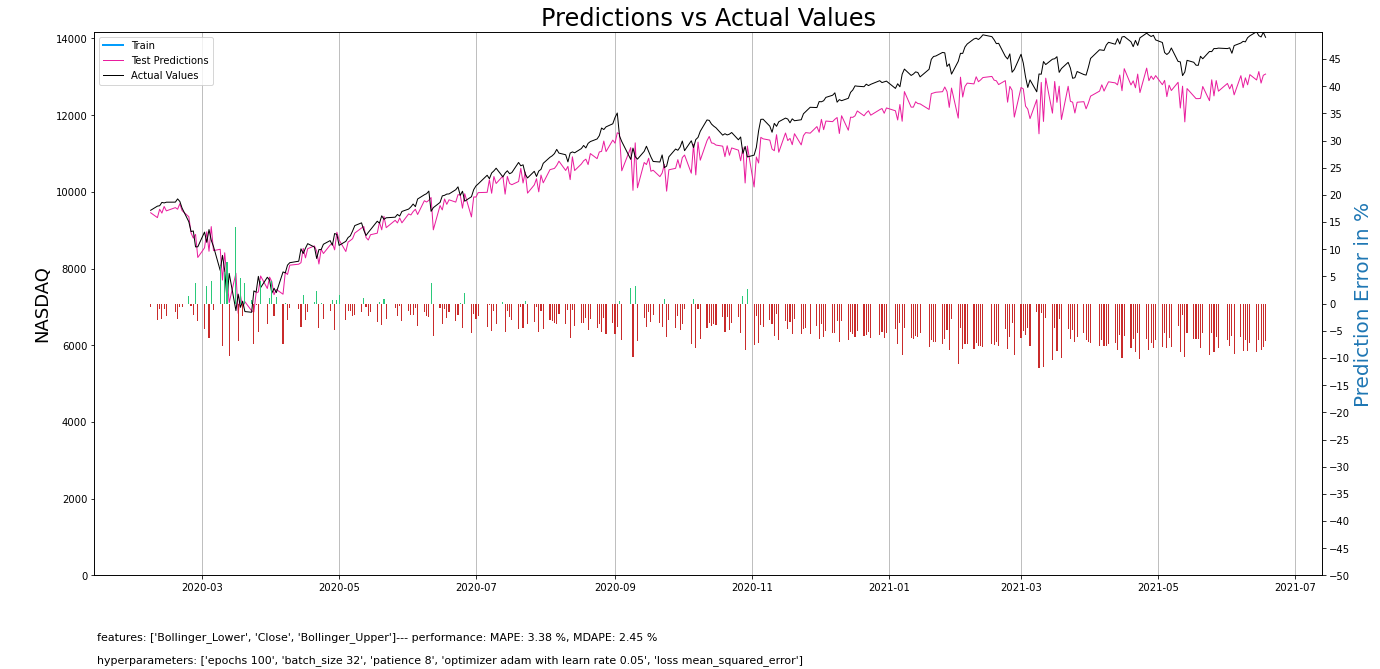

In [12]:
# Get the predicted values
y_pred = model.predict(x_test)

# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(y_pred.reshape(-1, 1))
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.round(np.mean((np.abs(np.subtract(y_test_unscaled, pred_unscaled)/ y_test_unscaled))) * 100, 2)
print('Mean Absolute Percentage Error (MAPE): ' + str(MAPE) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.round(np.median((np.abs(np.subtract(y_test_unscaled, pred_unscaled)/ y_test_unscaled)) ) * 100, 2)
print('Median Absolute Percentage Error (MDAPE): ' + str(MDAPE) + ' %')

# Mean Absolute Error (MAE)
print('Mean Absolute Error (MAE): ' + str(np.round(mean_absolute_error(y_test_unscaled, pred_unscaled), 4)))

# Mean Squared Error (MSE)
print('Mean Squared Error (MSE): ' + str(np.round(mean_squared_error(y_test_unscaled, pred_unscaled), 4)))

# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
# Shift the timeframe by 10 month
date_index = date_index_df[date_index_df['Date'] > use_start_date].copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Percentage Deviation", (valid["Prediction"] - valid["Close"]) * 100 / valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=24)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=1.0)
plt.plot(xv, yv["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Percentage Deviation"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

# Configure axis 1
ax1.set_ylim([0,max(valid["Close"])])

# Configure axis 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Prediction Error in %', color='tab:blue', fontsize=20)  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
ax2.set_yticks(np.arange(-50, 50, 5.0))
ax2.set_ylim([-50,50])
plt.bar(x, y, width=0.5, color=valid['diff_color'])
#ax1.xaxis.set_major_locator(plt.MaxNLocator(x.count()))

ax1.annotate('features: ' + str(assetname_list) + '--- performance: MAPE: ' + str(MAPE) + ' %, MDAPE: ' + str(MDAPE) + ' %', xy=(0.07, .04), xycoords='figure fraction', 
    horizontalalignment='left', verticalalignment='bottom', fontsize=11)
ax1.annotate('hyperparameters: ' + str(parameter_list), xy=(0.07, .005), xycoords='figure fraction', 
    horizontalalignment='left', verticalalignment='bottom', fontsize=11)

#Plot the chart
ax1.xaxis.grid()
plt.show()
#plt.savefig(assetname_list)